# <font color='blue'> Note: </font>

The csv file for this tutorial is available on the OWL Examples folder.

# Normalisation


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ignore df copy error, reduce distraction
import warnings
warnings.simplefilter('ignore')

RM_dataFrame = pd.read_csv("RM_9.csv",header=2,names = ('From Paper Index', 'Country', 'City, Location', 'Rock Classification',
       'Rock Type', 'Lithology', 'RQD', 'RMR76', 'RMR_89', 'Q', 'GSI',
       'Ei (GPa) (intact rock)', 'Em (GPa)', 'Eem (GPa)', 'Edm (GPa)',
       'σci (MPa) (intact rock)', 'Em test type'))

from sklearn import svm ## now we introduce sci-kit-learn for basic machine learning!
QA_RM = RM_dataFrame[RM_dataFrame["Q"].notna() & RM_dataFrame["Rock Classification"].notna() & RM_dataFrame["Em (GPa)"].notna()] ##only keep rows with known Q, classification, Em
QA_RM["Q_processed"] = np.log(QA_RM["Q"]) #Q is an exponential scale, so we take log of it
QA_RM["Q_processed"] = (QA_RM["Q_processed"] - QA_RM["Q_processed"].min())/(QA_RM["Q_processed"].max() - QA_RM["Q_processed"].min()) #scale log(Q) between min and max
QA_RM["Em_processed"] = (QA_RM["Em (GPa)"] - QA_RM["Em (GPa)"].min())/(QA_RM["Em (GPa)"].max() - QA_RM["Em (GPa)"].min()) # scale Em simply
# print(QA_RM.loc[:,["Q_processed","Em_processed"]])

X = QA_RM.loc[:, ("Q_processed", "Em_processed")].to_numpy() #convert inputs to numpy
Y = QA_RM.loc[:, ("Rock Classification")].to_numpy() #same for outputs

## load previous plotRM function

In [5]:
## for plotting
def plotRM(X,Y, clf):
  '''
  use the given classifor to plot scatters with heatmap in background
  ---------
  X: input array
  Y: label array
  clf: trained classifor instance from sklearn
  '''

  np.linspace(np.min(X[:,0]),np.max(X[:,0]),100)
  xx1, xx2 = np.meshgrid(np.linspace(np.min(X[:,0]),np.max(X[:,0]),100), np.linspace(np.min(X[:,1]),np.max(X[:,1]),100))
  Z = clf.predict(np.c_[xx1.ravel(), xx2.ravel()]) # column stack the flattened meshgrid array
  Z = Z.reshape(xx1.shape)
  color_dict = { 'Igneous':'red', 'Sedimentary':'blue', 'Metamorphic':'green'}
  plt.scatter(xx1.flatten(), xx2.flatten(), color=[ color_dict[i] for i in Z.flatten() ], alpha=0.1)
  plt.scatter(X[:,0], X[:,1], color=[ color_dict[i] for i in Y ], edgecolor='k')
  plt.xlabel("Q")
  plt.ylabel("Em (GPa)")

## train test split

Always remember to set aside part of your dataset for *model performance evaluation*.

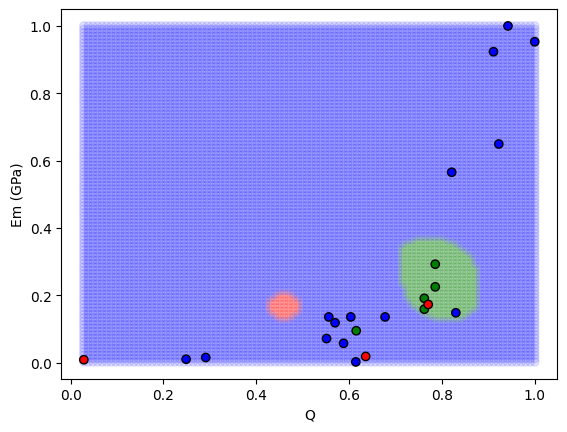

In [16]:
## split into train and test sets
np.random.seed(seed=1234)
all_idx = np.arange(0,len(X))
train_split = 0.8
train_idx = np.random.choice(all_idx,np.int(len(X)*train_split),replace=False) ###select 80% as train
test_idx = list(set(all_idx) - set(train_idx)) ##remaining 20% as test
X_train = X[train_idx,:] # create X,Y for train and test
Y_train = Y[train_idx]
X_test = X[test_idx,:]
Y_test = Y[test_idx]

clf = svm.SVC(kernel='rbf',gamma=100) ##
clf.fit(X_train, Y_train) #train model
plotRM(X_test,Y_test,clf)

# Metrics: precision and recall

![Figure](https://www.researchgate.net/profile/Marcelo-Campo/publication/216852769/figure/fig3/AS:669382636228635@1536604665503/Confusion-matrix-precision-and-recall-for-evaluating-the-recommended-patterns.png)

In [17]:

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
Y_predict = clf.predict(X_test)
acc = accuracy_score(Y_test, Y_predict)
recall = recall_score(Y_test, Y_predict,average='macro')
print("acc = {}, recall = {}".format(acc, recall))


acc = 0.782608695652174, recall = 0.5777777777777778


# Clustering

## load new dataset and check

In [ ]:
import pandas as pd

eq_df = pd.read_csv("/content/utc.csv",skiprows=0) #read in dataset for clustering
eq_df

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(eq_df["Easting (m)"],eq_df["Northing (m)"]) #plot data

## KMeans

In [ ]:
from sklearn.cluster import KMeans

n_cluster = 10
clusterer = KMeans(n_clusters=n_cluster) #create kmeans object
X = eq_df[["Easting (m)","Northing (m)"]].to_numpy() #create input array
cluster_labels = clusterer.fit_predict(X) #fit Kmeans clustering, get labels
plt.scatter(eq_df["Easting (m)"],eq_df["Northing (m)"],c=cluster_labels,cmap='nipy_spectral') #plot results
plt.colorbar()

In [ ]:
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm
import numpy as np

def plot_silhouette(X, cluster_labels,n_cluster): ##define function to calculate and plot silhouette scores

  sample_silhouette_values = silhouette_samples(X, cluster_labels) #generate silhouette scores

  fig, (ax1) = plt.subplots(1, 1) # make base fig for silhouette plot

  y_lower = 0
  for i in range(n_cluster): #this loop plots the silhouette scores onto the format shown in class
      # Aggregate the silhouette scores for samples belonging to
      # cluster i, and sort them
      ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

      ith_cluster_silhouette_values.sort()

      size_cluster_i = ith_cluster_silhouette_values.shape[0]
      y_upper = y_lower + size_cluster_i

      color = cm.nipy_spectral(float(i) / n_cluster)
      ax1.fill_betweenx(
          np.arange(y_lower, y_upper),
          0,
          ith_cluster_silhouette_values,
          facecolor=color,
          edgecolor=color,
          alpha=0.7,
      )

      # Label the silhouette plots with their cluster numbers at the middle
      ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

      # Compute the new y_lower for next plot
      y_lower = y_upper + 10  # 10 for the 0 samples
  return
plot_silhouette(X, cluster_labels,n_cluster)

## DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN #try dbscan

clustering = DBSCAN(eps=100, min_samples=2) #make dbscan object
clustering.fit(X)  #fit to data
cluster_labels = clustering.labels_ #extract labels

plt.scatter(eq_df["Easting (m)"],eq_df["Northing (m)"], c=cluster_labels, cmap='nipy_spectral') #plot results
plt.colorbar()

In [ ]:
plot_silhouette(X, cluster_labels,np.max(cluster_labels)+1) #generate similar silhouette plot

# PCA

In [ ]:
from sklearn.decomposition import PCA #import PCA package
RM_dataFrame = pd.read_csv("RM_9.csv") ## go back to rock mechanics database
pca = PCA(n_components=1) #create PCA object with 3 components
X = RM_dataFrame[["RQD","RMR89","GSI"]].dropna().to_numpy().astype(float) #create input array
print(X.shape) #check size of input array
pca.fit(X) #fit to data
print(pca.explained_variance_ratio_) #print eigenvalues
print(pca.components_) #print eigenvectors


In [ ]:

# project vectors to scalers by matrix multiplicatoin
# @: matrix multiplication for ndarray
# ndarray.T: transpose of the array to follow the rule of matmul shape
X_new = X@pca.components_.T #project selected number of components back to original data space
# print('\nShape of X:', X.shape, '\nShape of components: ', pca.components_.shape, '\nShape of matmul results: ', X_new.shape, '\n')
# print(np.hstack((X,X_new))) # print "unified" rock quality alongside inputs

X_new_scaled = np.matmul(-1*pca.components_,np.transpose(X)) #try projection, but use opposite direction of feature vector to preserve positive
print(X_new.shape, X.shape, X_new_scaled.shape)
X_new_scaled = 100*(X_new_scaled - np.min(X_new_scaled)) /(X_new_scaled.max() - X_new_scaled.min()) # scale it so it's between 0 and 100 like other indicators
print(np.hstack((X,X_new,np.transpose(X_new_scaled)))) # print scaled "unified" rock quality alongside inputs